# OFDM Get Ber from SNR

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#######################TRANSMISSION CARACTERISTICS##########################

K = 128 # number of OFDM subcarriers
CP = 16  # length of the cyclic prefix: 25% of the block
P = 8 # number of pilot carriers per OFDM block
#pilotValue = 3+3j # The known value each pilot transmits

allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])


# data carriers are all remaining carriers
dataCarriers = allCarriers

mu = 2 # bits per symbol (i.e. 4QAM)
payloadBits_per_OFDM = K*mu  # number of payload bits per OFDM symbol

In [9]:
mapping_table = {
    (1,1) : -1-1j,
    (1,0) : -1+1j,
    (0,1) :  1-1j,
    (0,0) :  1+1j
}
demapping_table = {v : k for k, v in mapping_table.items()}

In [29]:
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarrier
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]  
    return np.hstack([cp, OFDM_time]) 
def awgn(TX, var):
    num=len(TX)
    noisei = np.random.normal(0,var,num)
    noisej = 1j*np.random.normal(0,var,num)
    RX = TX[:]+noisei[:]+noisej[:]
    return RX
def removeCP(signal):
    return signal[CP:(CP+K)]
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
def get_payload(equalized):
    return equalized[dataCarriers]
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision
def PS(bits):
    return bits.reshape((-1,))

In [45]:
def bersnr(K, CP, P, bps, var):
    payloadBits_per_OFDM = K*bps  #
    bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
    bits_SP = SP(bits)
    QAM = Mapping(bits_SP)
    OFDM_data = OFDM_symbol(QAM)
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_TX = OFDM_withCP
    OFDM_RX = awgn(OFDM_TX,var)
    OFDM_RX_noCP = removeCP(OFDM_RX) 
    OFDM_demod = DFT(OFDM_RX_noCP)
    QAM_est = get_payload(OFDM_demod)
    PS_est, hardDecision = Demapping(QAM_est)
    bits_est = PS(PS_est)
    BER = np.sum(abs(bits-bits_est))/len(bits)

    return BER


In [46]:
bersnr(128, 16, 8, 2, 0.1)

0.21875

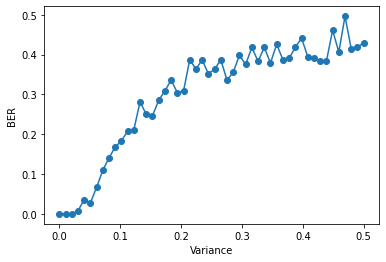

In [58]:
VARS= np.linspace(0,0.5,50)

BERS = np.array(list(map(lambda x:bersnr(128, 16, 8, 2, x), VARS)))

plt.plot(VARS,BERS, '-o')
plt.title("BER as a ")
plt.xlabel("Variance")
plt.ylabel("BER")
plt.show()